In [2]:
import pandas as pd
import numpy as np

### 第一部分：计算因子，将他们进行行业/市值/动量中性化

In [3]:
df_industry = pd.read_parquet('rawdata/industry.parquet')

In [7]:
df_factor = pd.read_parquet('eps_rawdata.parquet')

In [8]:
df_factor['EPS'] = df_factor['adj_net_profit']/df_factor['total_a']
df_factor = df_factor[['order_book_id','quarter','info_date','EPS']]
df_factor = df_factor.dropna()
df_factor = df_factor.sort_values(['info_date','order_book_id'])
df_industry = df_industry.sort_values(['date','order_book_id'])
df_factor = pd.merge_asof(df_industry,df_factor, left_on=['date'],right_on=['info_date'],by=['order_book_id'],direction='backward')

In [9]:
df_factor.groupby('date')['order_book_id'].count()

date
2016-01-04    2811
2016-01-05    2811
2016-01-06    2812
2016-01-07    2812
2016-01-08    2812
              ... 
2024-11-13    5109
2024-11-14    5109
2024-11-15    5109
2024-11-18    5109
2024-11-19    5109
Name: order_book_id, Length: 2157, dtype: int64

In [10]:
# 每日每股的行业分组和每股EPS
df_factor

,order_book_id,first_industry_code,date,quarter,info_date,EPS
0,000001,40,2016-01-04,2015q3,2015-10-23,0.430159
1,000002,42,2016-01-04,2015q3,2015-10-28,0.282450
2,000004,35,2016-01-04,2015q3,2015-10-31,0.036099
3,000005,42,2016-01-04,2015q3,2015-10-30,-0.007270
4,000006,42,2016-01-04,2015q3,2015-10-28,0.014235
...,...,...,...,...,...,...
8695268,688799,35,2024-11-19,2024q3,2024-10-29,0.425075
8695269,688800,60,2024-11-19,2024q3,2024-10-25,0.256306
8695270,688819,27,2024-11-19,2024q3,2024-10-30,0.304240
8695271,688981,60,2024-11-19,2024q2,2024-08-30,0.603862


In [11]:
# 每日每个行业的EPS中位数
result = df_factor.groupby(['first_industry_code', 'date']).agg( EPS_related_median=('EPS', 'median'),
                                               EPS_related_std=('EPS', 'std') ) 

result = result.reset_index()

In [12]:
result

,first_industry_code,date,EPS_related_median,EPS_related_std
0,10,2016-01-04,0.020667,0.124077
1,10,2016-01-05,0.020667,0.124077
2,10,2016-01-06,0.020667,0.124077
3,10,2016-01-07,0.020667,0.124077
4,10,2016-01-08,0.020667,0.124077
...,...,...,...,...
63752,70,2024-11-13,0.002238,0.065996
63753,70,2024-11-14,0.002238,0.065996
63754,70,2024-11-15,0.002238,0.065996
63755,70,2024-11-18,0.002238,0.065996


In [13]:
# 将行业中位数结果合并到factor表格中
df = pd.merge(df_factor,result,on=['first_industry_code','date'],how='outer')
df

,order_book_id,first_industry_code,date,quarter,info_date,EPS,EPS_related_median,EPS_related_std
0,000001,40,2016-01-04,2015q3,2015-10-23,0.430159,0.414577,1.465842
1,002142,40,2016-01-04,2015q3,2015-10-30,0.467757,0.414577,1.465842
2,600000,40,2016-01-04,2015q3,2015-10-30,0.715631,0.414577,1.465842
3,600015,40,2016-01-04,2015q3,2015-10-31,0.442614,0.414577,1.465842
4,600016,40,2016-01-04,2015q3,2015-10-31,0.398995,0.414577,1.465842
...,...,...,...,...,...,...,...,...
8695268,603958,34,2024-11-19,2024q3,2024-10-30,-0.133436,0.062887,0.150832
8695269,605003,34,2024-11-19,2024q3,2024-10-24,0.188610,0.062887,0.150832
8695270,605055,34,2024-11-19,2024q3,2024-10-31,-0.001105,0.062887,0.150832
8695271,605138,34,2024-11-19,2024q3,2024-10-29,0.017059,0.062887,0.150832


In [14]:
df.groupby('date')['order_book_id'].count().min()

2811

In [15]:
from backtesting import process_factors,neutralize_factors,calculate_and_plot_ic,calculate_benchmark_return,custom_quantile_grouping,get_pnl,plot_cumulative_returns,calculate_annual_metrics

In [16]:
# 假设一年是250个交易日

df['EPS_mean'] = df.groupby('order_book_id')['EPS'].rolling(250).mean().reset_index(0,drop=True)
df['EPS_std'] = df.groupby('order_book_id')['EPS'].rolling(250).std().reset_index(0,drop=True)
df['EPS_zscore'] = (df['EPS']-df['EPS_mean'])/df['EPS_std']

df['DST'] = df['EPS'] - df['EPS_related_median']
df['PRM'] = df['DST'] / df['EPS_related_std']


df['DST_mean'] = df.groupby('order_book_id')['DST'].rolling(250).mean().reset_index(0,drop=True)
df['DST_std'] = df.groupby('order_book_id')['DST'].rolling(250).std().reset_index(0,drop=True)
df['DST_zscore'] = (df['DST']-df['DST_mean'])/df['DST_std']

df['PRM_mean'] = df.groupby('order_book_id')['PRM'].rolling(250).mean().reset_index(0,drop=True)
df['PRM_std'] = df.groupby('order_book_id')['PRM'].rolling(250).std().reset_index(0,drop=True)
df['PRM_zscore'] = (df['PRM']-df['PRM_mean'])/df['PRM_std']


In [17]:
df_market = pd.read_parquet('rawdata/processed_market_data.parquet')

df_industry = pd.read_parquet('rawdata/industry.parquet')
df_industry['order_book_id'] = df_industry['order_book_id'].str[:6]

df_industry = pd.merge(df_market[['order_book_id','date']], df_industry, how = 'left')
df_industry['first_industry_code'] = df_industry['first_industry_code'].ffill()
df_industry.dropna(inplace=True)

df_industry = pd.get_dummies(df_industry, columns = ['first_industry_code'],prefix='industry')
df_industry = df_industry.astype({col: 'int' for col in df_industry.columns if col.startswith('industry_')})

In [18]:
df = pd.merge(df_market,df, on=['date','order_book_id'])


In [19]:
df = process_factors(df,factors= ['EPS'],process_method='rank')
df = neutralize_factors(df, factors=  ['EPS'], market_factor=False,momentum_factor=False, industry_factor=True, df_industry = df_industry)
df = df.drop(['industry_10', 'industry_11', 'industry_12',
       'industry_20', 'industry_21', 'industry_22', 'industry_23',
       'industry_24', 'industry_25', 'industry_26', 'industry_27',
       'industry_28', 'industry_30', 'industry_31', 'industry_32',
       'industry_33', 'industry_34', 'industry_35', 'industry_36',
       'industry_37', 'industry_40', 'industry_41', 'industry_42',
       'industry_43', 'industry_50', 'industry_60', 'industry_61',
       'industry_62', 'industry_63', 'industry_70'],axis=1)


yes,it is rank
Finish neutralize


In [20]:
df

,date,order_book_id,adj_close,adj_factor,adj_high,adj_low,adj_open,circulation_a,circulation_market_value,close,...,DST,PRM,DST_mean,DST_std,DST_zscore,PRM_mean,PRM_std,PRM_zscore,EPS_process,neu_EPS_process
0,2016-01-04,000001,7.631433,1.484649,8.102925,7.564077,8.082718,1.180405e+10,1.337399e+11,11.33,...,0.015582,0.010630,NaN,NaN,NaN,NaN,NaN,NaN,2397.0,77.0
1,2016-01-04,000004,41.310000,1.000000,46.600000,41.310000,45.900000,8.387546e+07,3.464895e+09,41.31,...,-0.074527,-0.440088,NaN,NaN,NaN,NaN,NaN,NaN,998.0,-578.0
2,2016-01-04,000005,9.040000,1.000000,10.000000,9.040000,10.000000,9.137430e+08,8.260237e+09,9.04,...,-0.030450,-0.130324,NaN,NaN,NaN,NaN,NaN,NaN,428.0,-572.0
3,2016-01-04,000006,8.336709,1.245096,9.252302,8.320646,9.204113,1.341487e+09,1.392464e+10,10.38,...,-0.008945,-0.038283,NaN,NaN,NaN,NaN,NaN,NaN,725.0,-275.0
4,2016-01-04,000008,10.427593,1.017493,11.675759,10.417765,11.675759,6.407281e+08,6.798125e+09,10.61,...,-0.006685,-0.034465,NaN,NaN,NaN,NaN,NaN,NaN,891.0,-173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8034450,2024-11-18,688799,39.840000,1.000000,40.980000,39.600000,40.200000,9.380000e+07,3.736992e+09,39.84,...,0.352074,0.684161,0.395507,0.048330,-0.898688,0.534816,0.110967,1.345845,4592.0,1942.0
8034451,2024-11-18,688800,37.080000,1.000000,38.580000,36.710000,38.360000,1.584199e+08,5.874209e+09,37.08,...,0.185552,0.645191,0.145984,0.058187,0.680030,0.468595,0.235298,0.750521,4151.0,1551.0
8034452,2024-11-18,688819,29.870000,1.000000,30.600000,29.650000,30.070000,9.721000e+08,2.903663e+10,29.87,...,0.238167,0.792643,0.497881,0.083799,-3.099227,1.712247,0.318025,-2.891609,4324.0,1812.0
8034453,2024-11-18,688981,92.300000,1.000000,97.500000,91.370000,95.700000,1.988359e+09,1.835255e+11,92.30,...,0.533108,1.853690,0.430195,0.193049,0.533090,1.290734,0.557461,1.009857,4757.0,2157.0


In [21]:
df.columns

Index(['date', 'order_book_id', 'adj_close', 'adj_factor', 'adj_high',
       'adj_low', 'adj_open', 'circulation_a', 'circulation_market_value',
       'close', 'halt_status', 'high', 'limit_down', 'limit_up', 'low',
       'num_trades', 'open', 'st_status', 'total_a', 'total_turnover',
       'turnover_rate', 'volume', 'st_change', 'halt_change', 'day_count',
       'ret_overnight', 'ret_day', 'ret_daily', 'first_industry_code',
       'quarter', 'info_date', 'EPS', 'EPS_related_median', 'EPS_related_std',
       'EPS_mean', 'EPS_std', 'EPS_zscore', 'DST', 'PRM', 'DST_mean',
       'DST_std', 'DST_zscore', 'PRM_mean', 'PRM_std', 'PRM_zscore',
       'EPS_process', 'neu_EPS_process'],
      dtype='object')

In [22]:
# sector_neu因子：对EPS做行业中性化后取其残差，即为sector_neu因子
df = df.rename(columns={'neu_EPS_process':'sector_neu'})
df['sector_neu_mean']= df.groupby('order_book_id')['sector_neu'].rolling(250).mean().reset_index(0,drop=True)
df['sector_neu_std'] = df.groupby('order_book_id')['sector_neu'].rolling(250).std().reset_index(0,drop=True)
df['sector_neu_zscore'] = (df['sector_neu']-df['sector_neu_mean'])/df['sector_neu_std']

In [25]:
# 所有要互相中性化的因子先做市值行业动量中性化。
df = process_factors(df,factors= ['DST_zscore','sector_neu_zscore','EPS_zscore','DST','sector_neu'],process_method='rank')
df = neutralize_factors(df, factors=['DST_zscore','sector_neu_zscore','EPS_zscore','DST','sector_neu'], market_factor=True,momentum_factor=True, industry_factor=True,df_industry = df_industry)


yes,it is rank
yes,it is rank
yes,it is rank
yes,it is rank
yes,it is rank
Finish neutralize


In [26]:
df = df.drop(['industry_10', 'industry_11', 'industry_12',
       'industry_20', 'industry_21', 'industry_22', 'industry_23',
       'industry_24', 'industry_25', 'industry_26', 'industry_27',
       'industry_28', 'industry_30', 'industry_31', 'industry_32',
       'industry_33', 'industry_34', 'industry_35', 'industry_36',
       'industry_37', 'industry_40', 'industry_41', 'industry_42',
       'industry_43', 'industry_50', 'industry_60', 'industry_61',
       'industry_62', 'industry_63', 'industry_70'],axis=1)
df

,date,order_book_id,adj_close,adj_factor,adj_high,adj_low,adj_open,circulation_a,circulation_market_value,close,...,EPS_zscore_process,DST_process,sector_neu_process,market_factor,momentum_factor,neu_DST_zscore_process,neu_sector_neu_zscore_process,neu_EPS_zscore_process,neu_DST_process,neu_sector_neu_process
0,2017-01-10,000001,7.505731,1.219069,7.513934,7.497528,7.505731,1.691799e+10,1.547996e+11,9.15,...,797.0,1202.0,1349.5,25.765397,0.026656,198.125000,76.062500,-76.500000,204.687500,120.250000
1,2017-01-10,000005,7.010000,1.000000,7.080000,7.010000,7.070000,9.512225e+08,6.668069e+09,7.01,...,1100.0,1042.0,708.0,22.620596,-0.091004,218.750000,67.687500,170.500000,-314.437500,-529.562500
2,2017-01-10,000006,7.973132,1.224111,8.128347,7.899609,8.103839,1.345151e+09,1.312868e+10,9.76,...,488.0,1048.0,711.0,23.298065,0.283033,-593.250000,-508.375000,-666.875000,-374.062500,-559.875000
3,2017-01-10,000009,8.636469,1.229669,8.734057,8.547014,8.555147,2.120066e+09,2.251510e+10,10.62,...,729.0,1783.0,1716.0,23.837452,0.034642,-353.125000,-145.875000,-422.750000,35.812500,58.375000
4,2017-01-10,000010,7.710000,1.000000,7.810000,7.690000,7.740000,4.079299e+08,3.145140e+09,7.71,...,1185.0,190.0,145.0,21.869124,0.010657,-21.250000,-189.500000,46.375000,-943.812500,-1120.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6724753,2024-11-18,688799,39.840000,1.000000,40.980000,39.600000,40.200000,9.380000e+07,3.736992e+09,39.84,...,1258.0,4587.0,4500.0,22.041547,0.055478,-1209.461198,1387.447657,-890.431122,2251.356881,2181.374417
6724754,2024-11-18,688800,37.080000,1.000000,38.580000,36.710000,38.360000,1.584199e+08,5.874209e+09,37.08,...,3699.0,4136.0,4122.5,22.493837,0.284989,830.893993,787.852118,1053.864935,1712.119199,1694.928027
6724755,2024-11-18,688819,29.870000,1.000000,30.600000,29.650000,30.070000,9.721000e+08,2.903663e+10,29.87,...,283.0,4326.0,4376.0,24.091824,0.180689,-2424.498501,-2388.002425,-2389.726518,1225.269503,1235.683623
6724756,2024-11-18,688981,92.300000,1.000000,97.500000,91.370000,95.700000,1.988359e+09,1.835255e+11,92.30,...,3383.0,4759.0,4721.0,25.935620,0.893181,-365.069692,-489.409925,-282.340354,1343.751032,1354.304177


### 第二部分：两两互相做中性化

#### DST  & sec_neu 

Finish neutralize


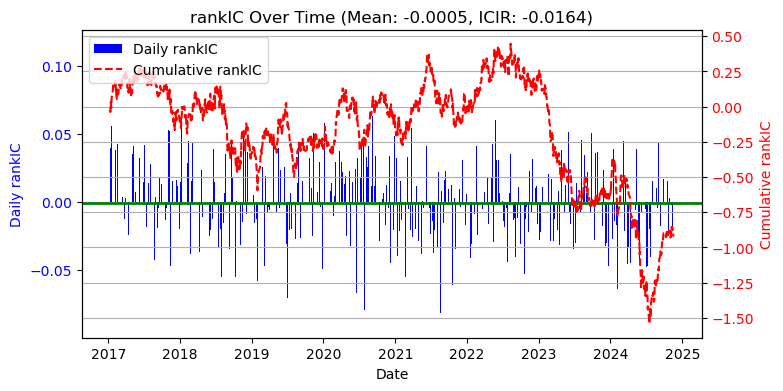

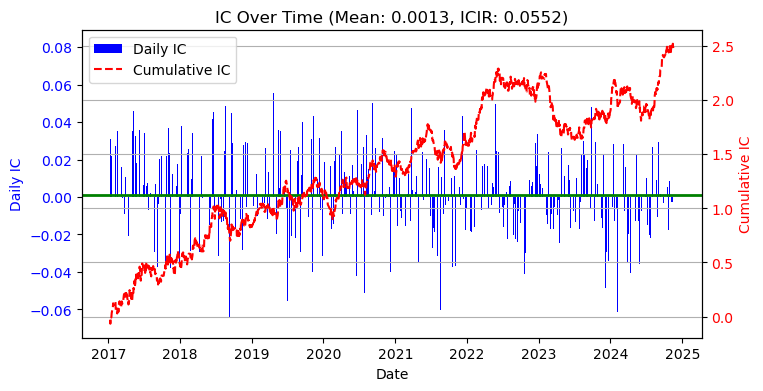

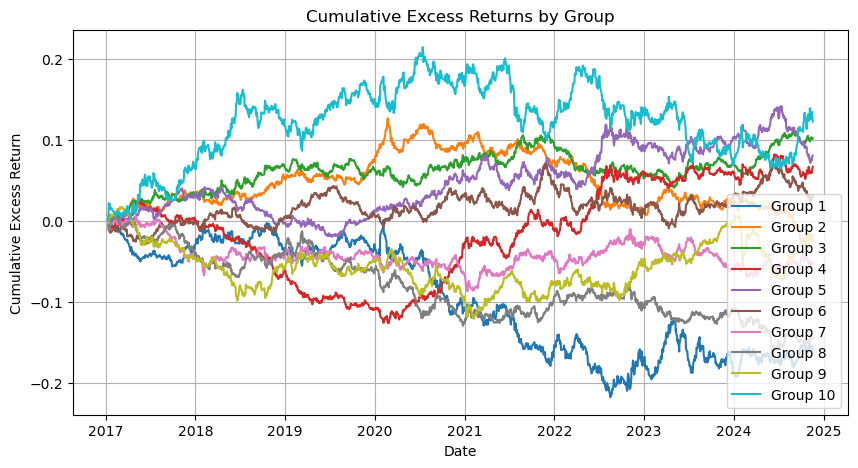

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.045957,-0.020958,-1.014884,-0.463011,0.083328
1,-0.062206,-0.003173,-2.223995,-0.113907,0.196777
2,-0.069949,0.013281,-2.599088,0.499904,0.277436
3,-0.096674,0.008721,-3.118778,0.284322,0.351315
4,-0.109685,0.010523,-3.358643,0.325603,0.400694
5,-0.113641,0.004085,-3.613608,0.131294,0.392420
6,-0.111725,-0.006880,-3.676321,-0.229609,0.349484
7,-0.113964,-0.018961,-3.615635,-0.610789,0.316678
8,-0.072124,-0.002563,-2.023666,-0.072579,0.231871


In [28]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=  ['neu_DST_process'], process=False, market_factor=False,momentum_factor=False, industry_factor=False, other='neu_sector_neu_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_DST_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_DST_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_DST_process'] = df1['neu_neu_DST_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_DST_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

Finish neutralize


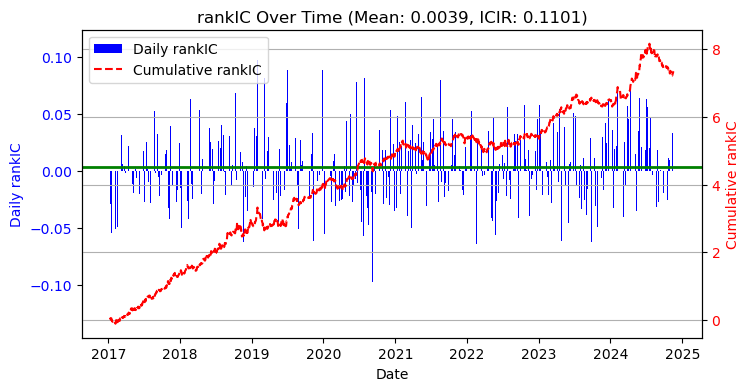

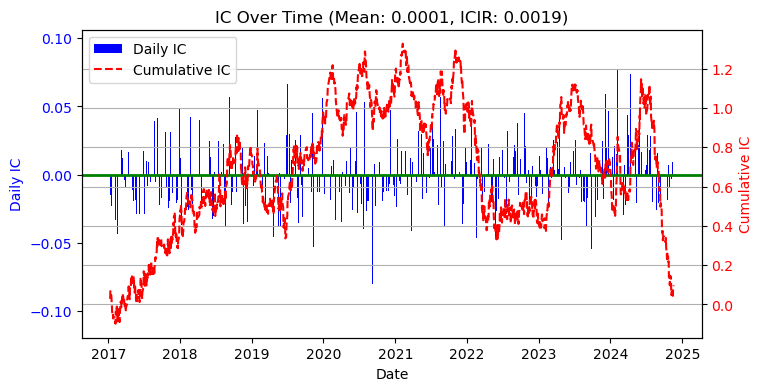

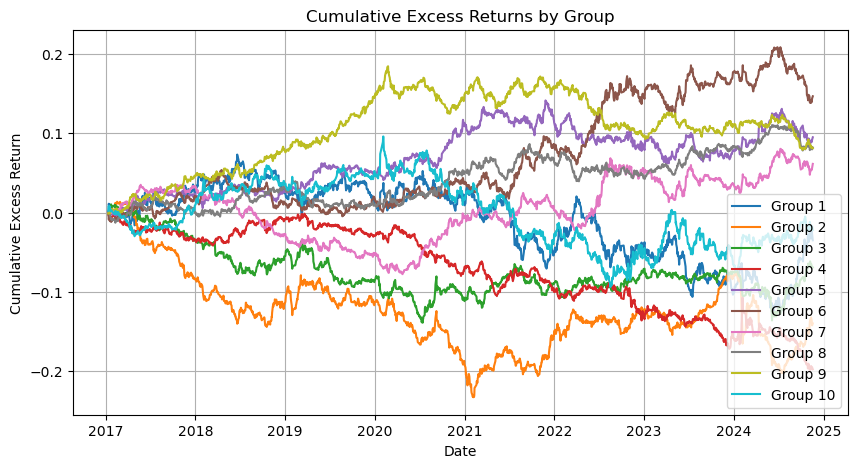

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.035479,-0.004596,-0.658107,-0.085331,0.102944
1,-0.089604,-0.018341,-2.207567,-0.455320,0.237545
2,-0.094246,-0.009080,-2.852253,-0.277372,0.283885
3,-0.117350,-0.025937,-3.676474,-0.826954,0.304711
4,-0.097451,0.012442,-2.881618,0.370978,0.366311
5,-0.102567,0.019225,-2.805076,0.528421,0.405972
6,-0.099492,0.008042,-3.138882,0.256241,0.358445
7,-0.071890,0.010742,-2.762673,0.416838,0.275439
8,-0.048181,0.010639,-1.645183,0.364563,0.196065


In [29]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=  ['neu_sector_neu_process'], process=False, market_factor=False,momentum_factor=False, industry_factor=False, other='neu_DST_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_sector_neu_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_sector_neu_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_sector_neu_process'] = df1['neu_neu_sector_neu_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_sector_neu_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

#### DST_ZSCORE & sec_neu_zscore 

Finish neutralize


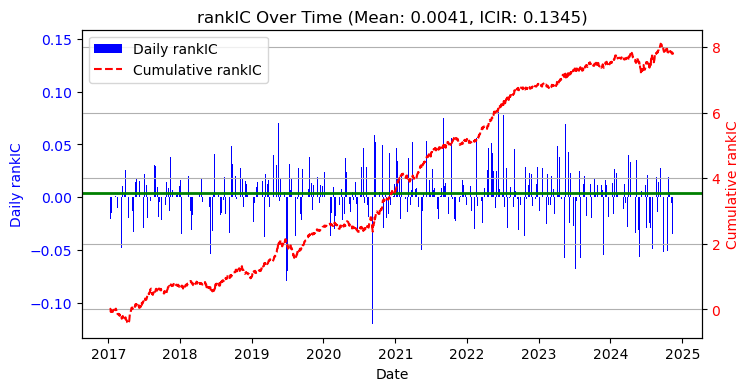

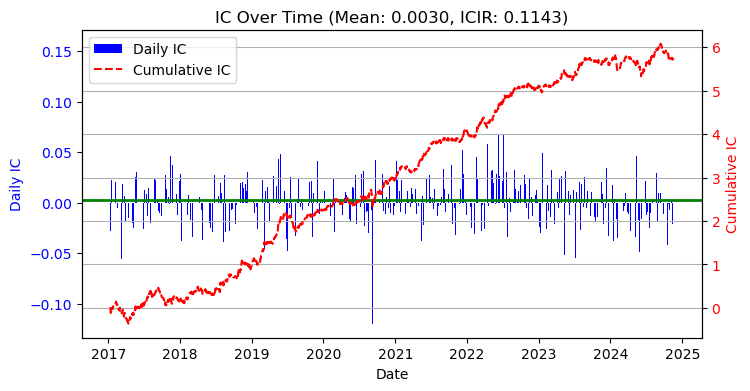

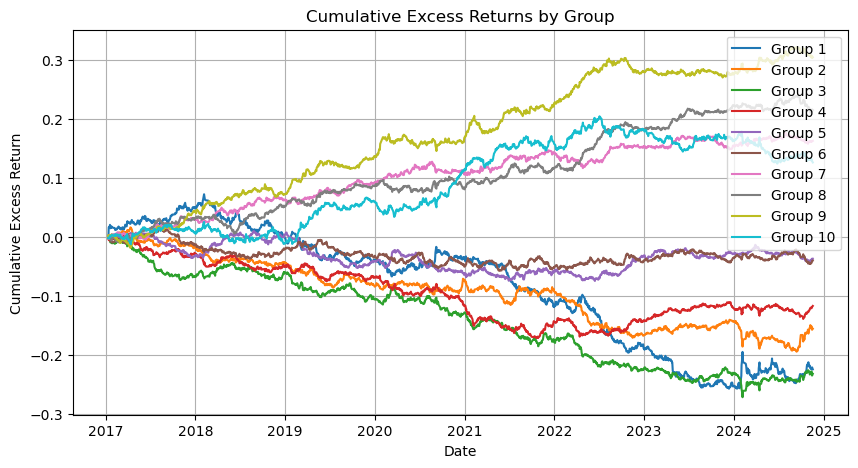

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.079958,-0.029503,-2.242531,-0.831091,0.168183
1,-0.141498,-0.020440,-5.136955,-0.756978,0.403529
2,-0.194774,-0.030483,-7.331396,-1.185913,0.547636
3,-0.200307,-0.015385,-8.455144,-0.674930,0.616407
4,-0.197575,-0.004875,-8.514140,-0.219911,0.642334
5,-0.198172,-0.005270,-8.903888,-0.247418,0.643008
6,-0.164669,0.021381,-7.348737,0.987914,0.620168
7,-0.136762,0.028246,-5.917417,1.258985,0.550027
8,-0.082188,0.039980,-3.040615,1.500492,0.407226


In [29]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=  ['neu_DST_zscore_process'], process=False, market_factor=False,momentum_factor=False, industry_factor=False, other='neu_sector_neu_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_DST_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_DST_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_DST_zscore_process'] = df1['neu_neu_DST_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_DST_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

Finish neutralize


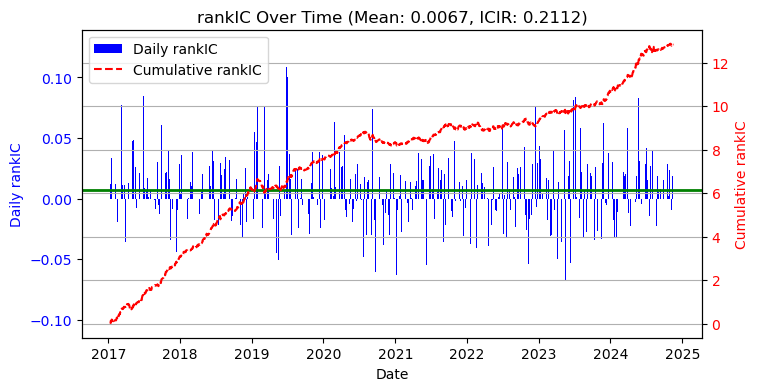

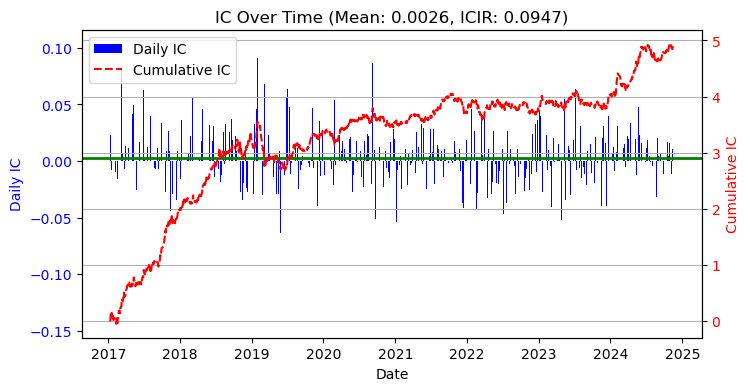

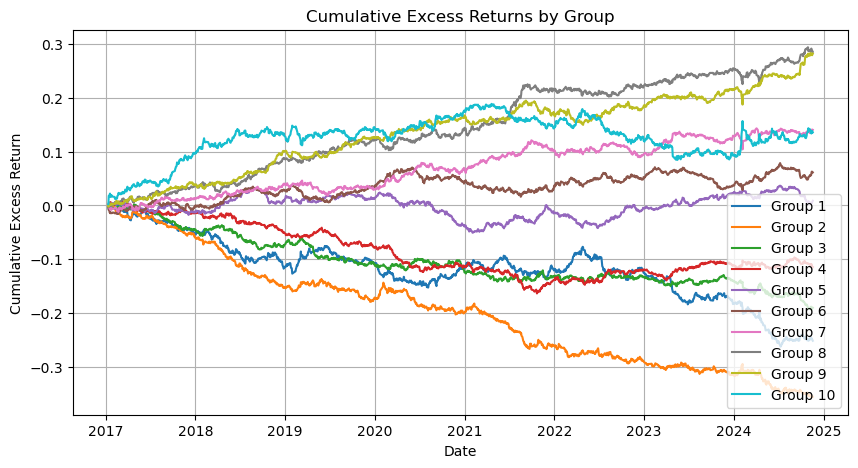

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.087424,-0.032943,-2.843580,-1.078170,0.181602
1,-0.173337,-0.046563,-6.458842,-1.779565,0.422580
2,-0.194497,-0.024906,-8.213697,-1.089748,0.565302
3,-0.207366,-0.015003,-9.207921,-0.693799,0.641211
4,-0.200626,0.001128,-8.574648,0.050993,0.672513
5,-0.196459,0.008036,-8.411335,0.358625,0.681648
6,-0.179900,0.018382,-7.502692,0.791898,0.660940
7,-0.139677,0.037389,-5.356622,1.462796,0.590217
8,-0.093464,0.036931,-3.580450,1.440315,0.434650


In [30]:
dftemp = df.copy()

dftemp = neutralize_factors(dftemp, factors=  ['neu_sector_neu_zscore_process'], process=False, market_factor=False,momentum_factor=False, industry_factor=False,other='neu_DST_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_sector_neu_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_sector_neu_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_sector_neu_zscore_process'] = df1['neu_neu_sector_neu_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_sector_neu_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))
calculate_annual_metrics(pnl_result)

#### DST_ZSCORE & EPS_zscore 

Finish neutralize


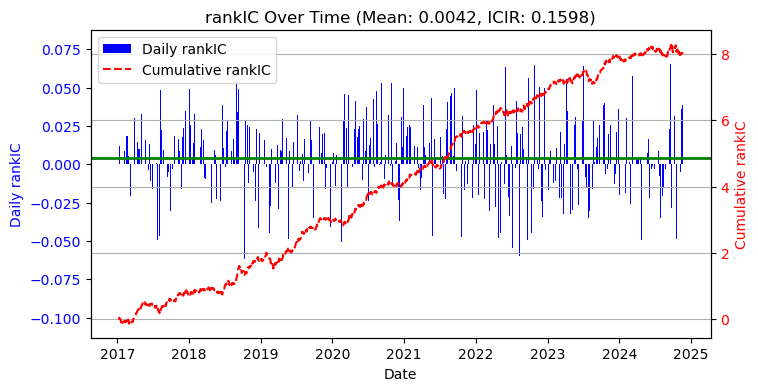

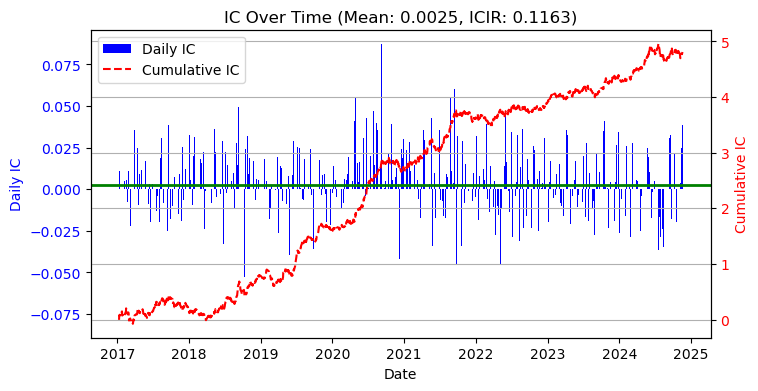

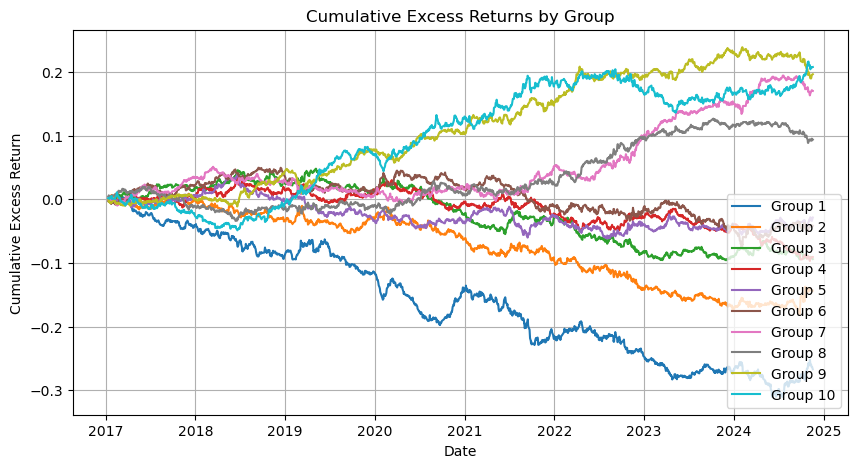

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.058948,-0.035041,-1.770450,-1.059788,0.079690
1,-0.071859,-0.018844,-2.480680,-0.661994,0.176716
2,-0.082953,-0.012335,-3.253644,-0.495820,0.235394
3,-0.093424,-0.011916,-3.867699,-0.509821,0.271692
4,-0.091103,-0.003772,-3.538655,-0.148729,0.291103
5,-0.093037,-0.005473,-3.378048,-0.202186,0.291883
6,-0.058898,0.022314,-2.275145,0.887232,0.270704
7,-0.057142,0.012287,-2.294157,0.504014,0.231429
8,-0.025966,0.025757,-0.972267,0.985706,0.172410


In [31]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=  ['neu_EPS_zscore_process'], process=False, market_factor=False,momentum_factor=False, industry_factor=False, other='neu_DST_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_EPS_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_EPS_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_EPS_zscore_process'] = df1['neu_neu_EPS_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_EPS_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

Finish neutralize


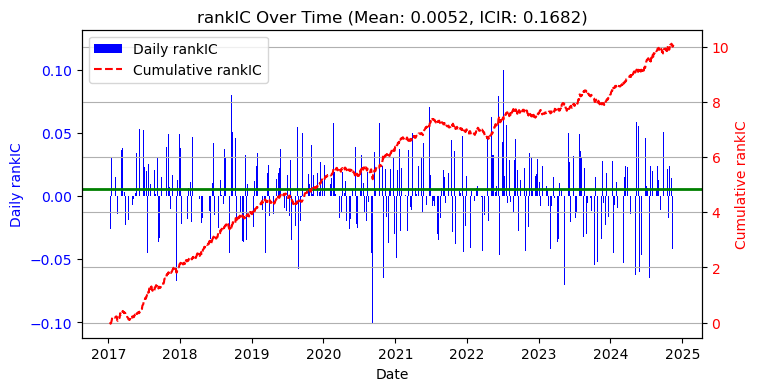

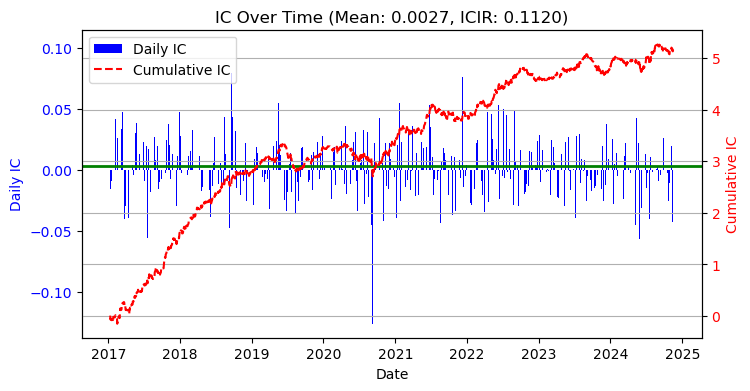

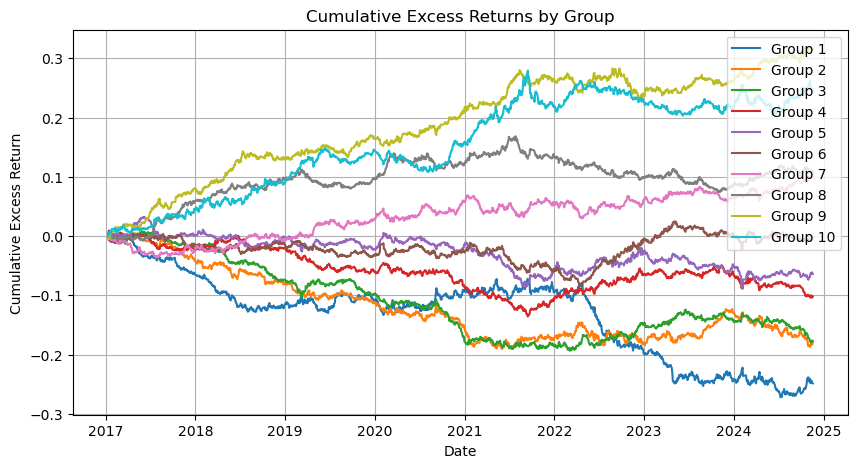

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.057365,-0.032598,-1.648280,-0.941335,0.082557
1,-0.077056,-0.023545,-2.573067,-0.798498,0.178368
2,-0.093611,-0.023211,-3.696412,-0.939869,0.234665
3,-0.094820,-0.013361,-3.708426,-0.537618,0.271527
4,-0.096658,-0.008378,-3.535779,-0.312764,0.294266
5,-0.089393,-0.000216,-3.361735,-0.008267,0.297258
6,-0.069506,0.013929,-2.726182,0.561762,0.278119
7,-0.058487,0.014220,-2.251696,0.558908,0.242357
8,-0.014541,0.041359,-0.468627,1.352175,0.186333


In [32]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=  ['neu_DST_zscore_process'],process=False,market_factor=False,momentum_factor=False, industry_factor=False, other='neu_EPS_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_DST_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_DST_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_DST_zscore_process'] = df1['neu_neu_DST_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_DST_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

#### EPS_zscore & SECTOR_neu

Finish neutralize


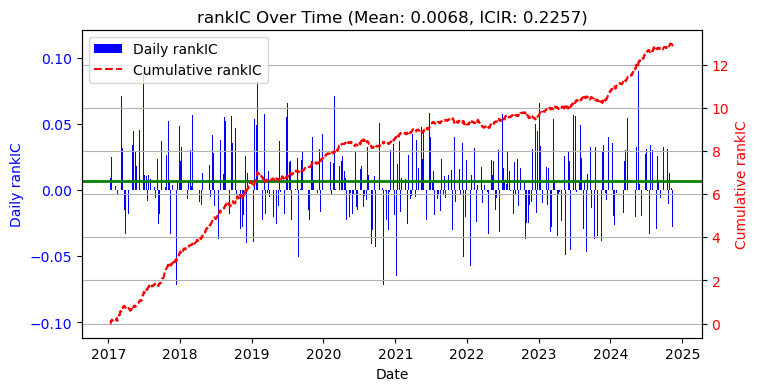

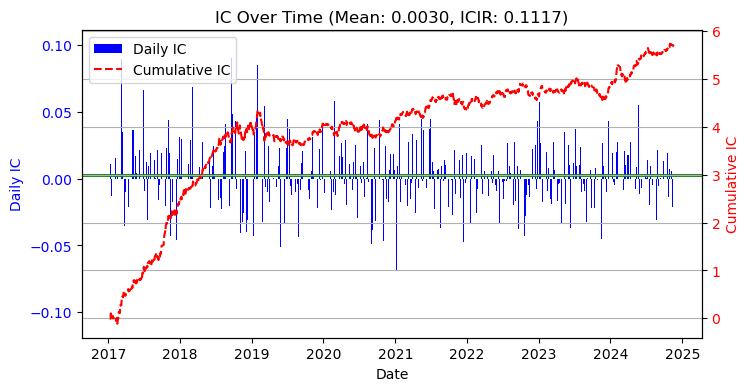

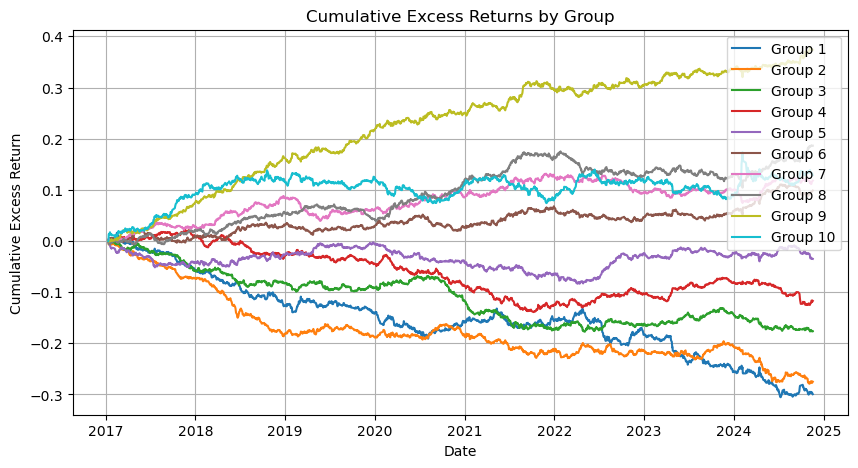

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.086663,-0.039294,-2.833183,-1.292811,0.157894
1,-0.141289,-0.036097,-5.629939,-1.469627,0.350638
2,-0.160928,-0.023156,-6.847096,-1.013365,0.459240
3,-0.173736,-0.015371,-7.613629,-0.695190,0.527885
4,-0.173569,-0.004587,-7.608057,-0.207910,0.563271
5,-0.158727,0.012927,-7.026683,0.593188,0.572181
6,-0.150152,0.015468,-6.429120,0.678926,0.552066
7,-0.123005,0.024426,-4.965468,1.013397,0.491436
8,-0.063582,0.049017,-2.495512,1.935035,0.375330


In [33]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=['neu_sector_neu_zscore_process'],process=False, market_factor=False,momentum_factor=False, industry_factor=False, other='neu_EPS_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_sector_neu_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_sector_neu_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_sector_neu_zscore_process'] = df1['neu_neu_sector_neu_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_sector_neu_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

Finish neutralize


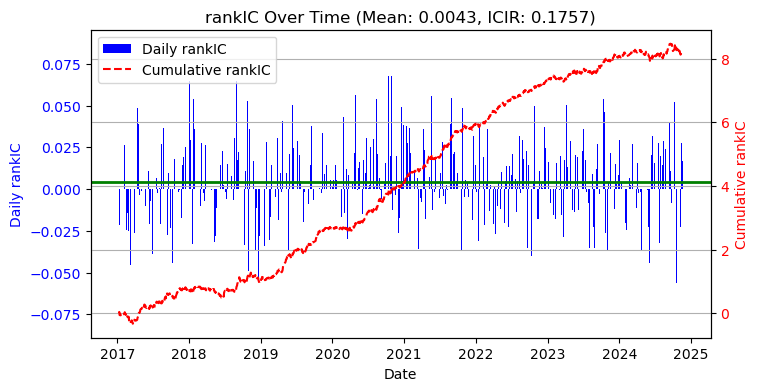

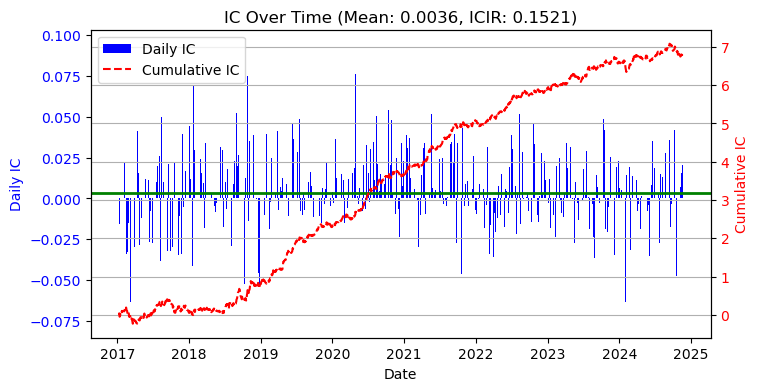

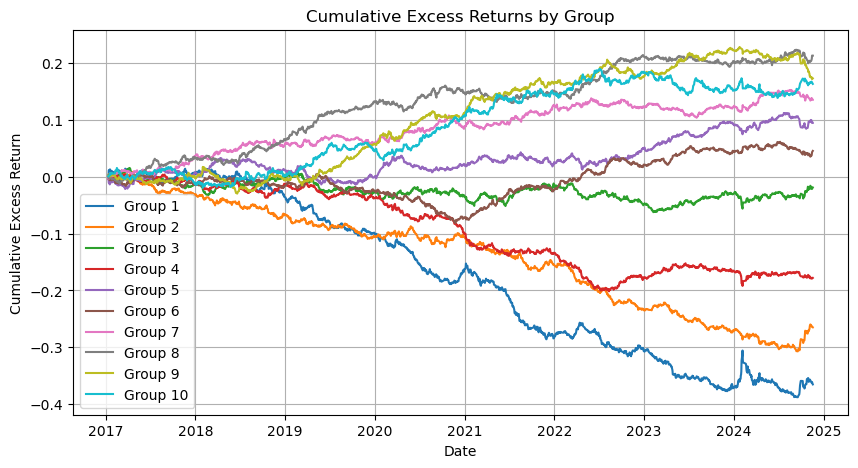

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.090857,-0.047933,-2.899308,-1.537043,0.143082
1,-0.134116,-0.034753,-5.442885,-1.436236,0.331209
2,-0.134862,-0.002435,-5.580508,-0.103786,0.441424
3,-0.174598,-0.023334,-7.600428,-1.041992,0.504215
4,-0.147424,0.012490,-6.473148,0.563850,0.533047
5,-0.153674,0.006009,-7.070851,0.285820,0.532277
6,-0.131921,0.017822,-6.142141,0.855726,0.499143
7,-0.101219,0.028019,-4.413621,1.250913,0.430794
8,-0.073456,0.022777,-3.105545,0.981648,0.320775


In [35]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=  ['neu_EPS_zscore_process'], process=False,market_factor=False,momentum_factor=False, industry_factor=False, other='neu_sector_neu_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_EPS_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_EPS_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_EPS_zscore_process'] = df1['neu_neu_EPS_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_EPS_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)